In [24]:
import numpy as np
from numpy.linalg import LinAlgError
from scipy.linalg import circulant
import math
import random

from tqdm import tqdm
from PIL import Image
from matplotlib import cm

def log_density_map(val, max_count): 
    brightness = math.log(val) / math.log(max_count)
    gamma = 2.2
    brightness = math.pow(brightness, 1/gamma)
    return brightness


def complex_to_image(z, width, height, real_range, imag_range, centered_at):
    bottom_left = centered_at - complex(real_range / 2, imag_range / 2)
    # Find x coordinate
    x = (z.real - bottom_left.real) / real_range # Normalized
    x *= width

    # Find y coordinate
    y = (z.imag - bottom_left.imag) / imag_range # Normalized
    y = 1 - y
    y *= height

    return (int(x), int(y))
  

def beta_real_circulant(n, elemets):
    offset = -1
    p = 2*np.random.beta(0.01, 0.01, (n)).astype(complex) + offset
    return  circulant(p) 


def batch_regular_circulant_matrices(batch_size, n, values, generator):
    A = np.zeros((batch_size, n, n)).astype(complex)
    
    for i in range(batch_size):
        A[i, :, :] = generator(n, values)
    warn = 0
    try:
        E = np.linalg.eigvals(A)
    except LinAlgError:
        E = 0
        warn = 1
    return E, warn



def bohem_circ_regular(n, im_arr, width, height, real_range, imag_range, centered_at, cmap, samples, generator):
    batch = 5000
    values = [-1, 1]

    counts = np.zeros((width, height), dtype=np.uint64)

    bac = (239, 235, 216)  
    #bac = (20, 30, 20)  

    for _ in tqdm(range(samples//batch)):
        eigvalsArr, warn = batch_regular_circulant_matrices(batch, n, values, generator)

        if warn:
            continue

        for eigvals in eigvalsArr:

            for z in eigvals:
                x, y = complex_to_image(z, width, height, real_range, imag_range, centered_at)

                if (0 <= x < width) and (0 <= y < height):
                    counts[y, x] += 1

    max_count = np.max(counts)

    for y in tqdm(range(height)):
        for x in range(width):
            if counts[y, x]:
                rgba = cmap( log_density_map(counts[y, x], max_count))
                im_arr[y, x, 0] = int(255 * rgba[0])
                im_arr[y, x, 1] = int(255 * rgba[1])
                im_arr[y, x, 2] = int(255 * rgba[2])
            else:
                im_arr[y, x, 0] =  bac[0]
                im_arr[y, x, 1] =  bac[1]
                im_arr[y, x, 2] =  bac[2]

    im = Image.fromarray(im_arr)

    return im


def render_picture_histogram(N = 5,
                            centered_at = complex(0, 0),
                            r = 1,
                            scale = 6, #12 #3.6
                            samples = 100_000, 
                            width = 500,
                            cmap_name = "copper_r" ):
    

    real_offset = (centered_at.real - r, centered_at.real + r)
    imag_offset = (centered_at.imag - r, centered_at.imag + r)

    real_range = real_offset[1] - real_offset[0]
    imag_range = imag_offset[1] - imag_offset[0]

    real_range *= scale
    imag_range *= scale

    aspect_ratio = real_range / imag_range

    height = int(width * 1 / aspect_ratio)
    
    cmap = cm.get_cmap(cmap_name)
    
    im_arr = np.zeros((height, width, 3), dtype=np.uint8)

    im = bohem_circ_regular(N, im_arr, width, height, real_range, imag_range, centered_at,cmap, samples, beta_real_circulant)

    print(f"Saving image...{width}_{height}_samples_{samples}")

    name = f"{N}_{width}_{height}_samples_{samples}_scale_{scale}.png"

    #im.save(name)

    display(im)





100%|██████████| 500/500 [00:00<00:00, 507.09it/s]

Saving image...500_500_samples_100000


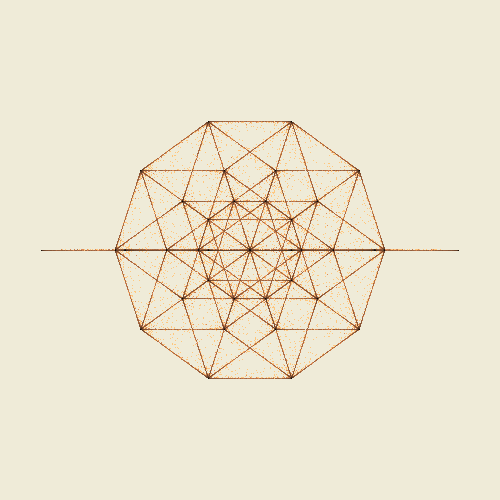

In [25]:
N = 5

render_picture_histogram(N)

100%|██████████| 50000/50000 [00:04<00:00, 10938.36it/s]


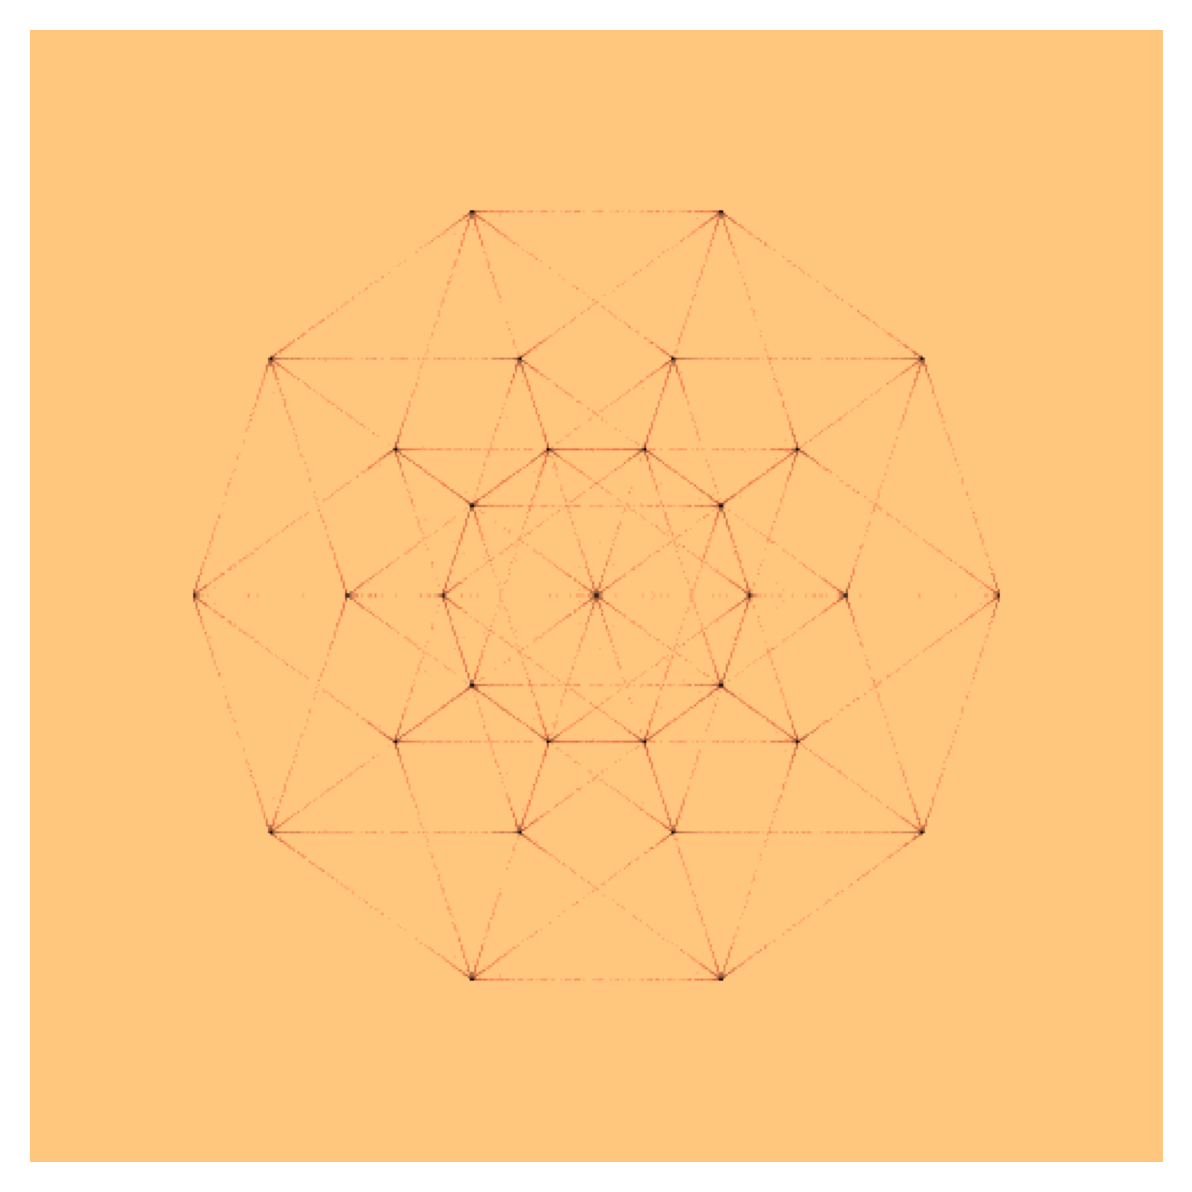

In [37]:
import numpy as np
from scipy.linalg import circulant
import math

params = {
    'n_matrices': 50_000,
    'picture_size': 500,
    'dimensions': 5,
    'scale': 0.11,
    'tr_x': 0,
    'tr_y': 0,
}

def m_show(m, size = 5, cmap = 'copper_r'):
    import matplotlib.pyplot as plt
    from numpy import array
    cmaps =  ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']
    plt.figure(num = None, figsize=(size, size), dpi=300)
    plt.axis('off')
    plot = plt.imshow(array(m), cmap = cmap) #, interpolation='bicubic' )
    plt.show()
    plt.close()

def log_density_map(val, max_count):
    max_count +=1
    brightness = math.log(val) / math.log(max_count+1)
    gamma = 1.2
    brightness = math.pow(brightness, 1/gamma)
    return 256*brightness


def generate_random_matrix(n):
    p = 2*np.random.beta(0.01, 0.01, (n)).astype(complex) - 1
    temp_matrix = circulant(p)
    eigs = np.linalg.eigvals(temp_matrix)
    return eigs

def prep_m(m):
    max_v = np.max(m)
    shape = m.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            if m[i][j] > 0:
                m[i][j] = log_density_map(m[i][j], max_v)
    return m

def form_eigs_matrix(params):
    from math import floor 
    from tqdm import tqdm 

    N = params['n_matrices']
    M_size = params['picture_size']
    sc = params['scale']
    D = params['dimensions']
    dx = params['tr_x']
    dy = params['tr_y']

    base_mat = np.zeros((M_size, M_size), dtype=int)

    for i in tqdm(range(N)):

        eigs = generate_random_matrix(D)

        for r in eigs:
            if abs(r.imag) > 0.000001:
                x = floor((r.real +dx)*M_size*sc + M_size/2)
                y = floor((r.imag +dy)*M_size*sc + M_size/2)

                if 0 <= x < M_size and 0 <= y < M_size:
                    base_mat[y][x] += 1

    return base_mat

m = form_eigs_matrix(params)
m = prep_m(m)
m_show(m)